In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
dir = os.getcwd()

In [2]:
df = pd.read_csv(dir+'/data/merged.csv')

In [3]:
#날짜를 인덱스로 설정
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df1 = df.copy().dropna() #결측치 제거

#문자로 된 자료 숫자로 바꿔주기
for a in df1.columns:
    df1[a] = df1[a].astype('float')
    

In [4]:
#장단기 스프레드 // 출하지수-재고지수 스프레드
df1['y_spd'] = df1['10y'] - df1['3y']
df1['manu_spd'] = df1['shipment'] - df1['inven']
df1['manu_ratio'] = (df1['shipment'] / df1['inven'])-1 #스프레드하면 스케일이 약간 애매해져서, 양 지수에 로그취해서 빼줌

In [5]:
#설비투자전망지수 대기업+중소기업 평균 산출
df1['bsi_inv'] = (df1['bsi_inv_big'] + df1['bsi_inv_small']) / 2

In [6]:
df1.columns

Index(['bsi_inv_big', 'bsi_inv_small', '3y', '10y', 'shipment', 'inven', 'ipi',
       'employ', 'durable', 'wti', 'dubai', 'iron', 'copper', 'gold', 'y_spd',
       'manu_spd', 'manu_ratio', 'bsi_inv'],
      dtype='object')

In [7]:
#필요없는거 제거
df2 = df1.drop(columns=['bsi_inv_big', 'bsi_inv_small','10y', '3y', 'shipment', 'inven',
                        'wti','iron', 'copper', 'gold'])

In [8]:
#샘플기간 분리: 기준일 2017-07-01부터 out of sample
df2_train = df2['2003-02-01':'2017-06-01']
df2_test = df2['2017-07-01':]

In [9]:
from sklearn.preprocessing import StandardScaler
#PCA 함수: 데이터프레임을 인풋으로
#PCA 결과들을 리스트에 모아서 리턴해줌

def pca(x):
    '''
    데이터프레임을 인풋으로
    PCA 결과들을 딕셔너리에 모아서 리턴해줌
    딕셔너리 키 목록
    1. df_scaled: 표준화된 데이터
    2. cov_matrix: 표준화된 데이터의 공분산 행렬
    3. eigenvalues_df: eigenvalues
    4. eigenvectors_df: eigenvectors
    5. explained_variance_ratio_df: 분산 설명비율
    '''
    scaler = StandardScaler() # standard normal
    df_scaled = scaler.fit_transform(x) #데이터 표준화
    cov_matrix = np.cov(df_scaled, rowvar=False) #공분산 행렬 계산
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) #아이겐벡터, 밸류 계산
    principal_components = df_scaled.dot(eigenvectors[:, 0])  # 첫 번째 주성분(PC1)

    # PC1 방향을 나타내는 벡터
    pc1_vector = eigenvectors[:, 0]

    #Explained Variance Ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

    #PCA 결과 저장
    index = []
    for i in range(0,len(x.columns)):
        index.append(f'PC{i+1}')

    cov_matrix_df = pd.DataFrame(cov_matrix, columns=x.columns, index=x.columns)
    eigenvalues_df = pd.DataFrame({'Eigenvalues': eigenvalues}, index=index)
    eigenvectors_df = pd.DataFrame(eigenvectors, columns=index,
                                index=x.columns)
    explained_variance_ratio_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio},
                                            index=index)
    result = {'df_scaled' : df_scaled,
              'cov_matrix' : cov_matrix,
              'eigenvalues' : eigenvalues_df,
              'eigenvectors' : eigenvectors_df,
              'explained_variance' : explained_variance_ratio_df}
    print(result.keys())
    return result

In [13]:
pca_result = pca(df2_train)

dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])


In [14]:
pca_result['explained_variance']

,Explained Variance Ratio
PC1,0.422065
PC2,0.266567
PC3,0.161100
PC4,0.075843
PC5,0.002354
PC6,0.000884
PC7,0.044252
PC8,0.026935


In [15]:
#pca1의 주성분을 PC1, PC2, PC3로 설정
#표준화된 X 랑 eigenvector 곱하기
data_pc = pca_result['df_scaled']@pca_result['eigenvectors'][['PC1', 'PC2', 'PC3']]

In [16]:
# 변동 설명력 기준으로 가중 선정해서 지수 산출 vs 동일가중 산출
data_pc['growth_indicator'] = data_pc['PC1'] + data_pc['PC2'] + data_pc['PC3']

In [19]:
data_pc

,PC1,PC2,PC3,growth_indicator
0,1.287073,1.974222,-1.031252,2.230043
1,1.117672,2.382272,-0.655780,2.844164
2,0.821870,3.108601,0.115848,4.046319
3,0.907454,2.903113,-0.102306,3.708261
4,1.011561,3.010051,0.021578,4.043190
...,...,...,...,...
168,-3.004218,-0.110643,0.348029,-2.766832
169,-2.794128,-0.409127,0.149572,-3.053682
170,-2.957509,-0.514508,0.038755,-3.433262
171,-3.363413,-0.186988,0.291694,-3.258708


In [20]:
data_pc['ewma'] = data_pc['growth_indicator'].ewm(span=20).mean()

In [21]:
data_pc

,PC1,PC2,PC3,growth_indicator,ewma
0,1.287073,1.974222,-1.031252,2.230043,2.230043
1,1.117672,2.382272,-0.655780,2.844164,2.552457
2,0.821870,3.108601,0.115848,4.046319,3.100994
3,0.907454,2.903113,-0.102306,3.708261,3.276303
4,1.011561,3.010051,0.021578,4.043190,3.461806
...,...,...,...,...,...
168,-3.004218,-0.110643,0.348029,-2.766832,-2.619198
169,-2.794128,-0.409127,0.149572,-3.053682,-2.660577
170,-2.957509,-0.514508,0.038755,-3.433262,-2.734166
171,-3.363413,-0.186988,0.291694,-3.258708,-2.784123


<Axes: >

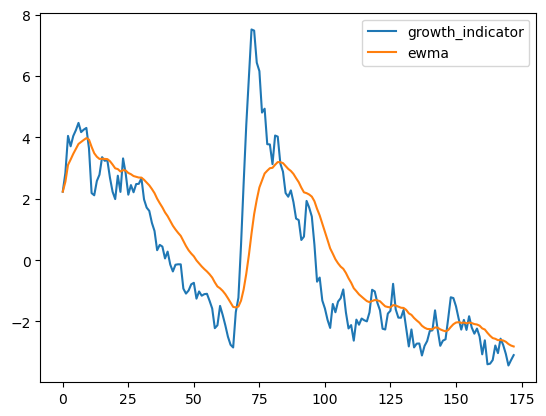

In [22]:
data_pc[['growth_indicator','ewma']].plot()

In [30]:
pca_result['explained_variance'].loc['PC1']

Explained Variance Ratio    0.3781
Name: PC1, dtype: float64

In [33]:
data_pc

,PC1,PC2,PC3,growth_indicator
0,0.210103,-1.073777,-1.455777,NaN
1,0.445232,-1.554950,-1.265342,NaN
2,0.810774,-2.425195,-0.800921,NaN
3,0.660436,-2.191102,-0.970154,NaN
4,0.701002,-2.398183,-0.927822,NaN
...,...,...,...,...
168,2.189377,0.579268,0.905226,NaN
169,1.951258,0.794795,0.711118,NaN
170,1.943546,1.023714,0.707615,NaN
171,2.285253,0.771250,0.905479,NaN


In [ ]:
from statsmodels.tsa.ar_model import AutoReg

dates = [] #결과저장: 날짜
fitted = [] #결과저장: 예측된 growth indicator
x_list = ['employ', 'durable', 'dubai', 'y_spd', 'manu_spd', 'bsi_inv'] #대상 변수 바꾸고싶으면 이 부분 수정

for i in range(0,len(df2_test.index)):
    time = df2_test.index[i] + pd.DateOffset(months=-1) # 예측값 얻고 싶은 날짜
    temp = df2['2003-02-01':time] # 데이터셋 이름 바뀌면 이 부분 수정
    temp = temp[x_list] #분석 대상 변수들 -> df2에서 가져옴
    pca_result = pca(temp) #PCA 진행

    #pca1의 주성분을 PC1, PC2, PC3로 설정
    #표준화된 X 랑 eigenvector 곱하기
    data_pc = pca_result['df_scaled']@pca_result['eigenvectors'][['PC1', 'PC2', 'PC3']]

    # Growth indicator 산출하는 부분
    # 각 지표별 가중치 변경하려면 이 부분 수정하기
    w1 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[0]
    w2 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[0]
    w3 = pca_result['explained_variance']['Explained Variance Ratio'].iloc[0]

    data_pc['growth_indicator'] = data_pc['PC1']*w1 + data_pc['PC2']*w2 + data_pc['PC3']*w3

    # AR(1) 모델 피팅
    x = data_pc['growth_indicator']
    model = AutoReg(x, lags=1)  # 1 시차를 사용하는 AR(1) 모델
    model_fitted = model.fit()

    # 예측 수행
    pred = model_fitted.predict(start=len(x), end=len(x))
    dates.append(time + pd.DateOffset(months=1))
    fitted.append(pred.values[0])
    growth_fitted = pd.DataFrame({'date': dates, 'growth_indicator': fitted})
    growth_fitted.set_index('date', inplace=True)
    
    


dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])


AttributeError: 'numpy.ndarray' object has no attribute 'emw'

In [35]:
growth_fitted = pd.DataFrame({'date': dates, 'growth_indicator': fitted})

In [36]:
growth_fitted.set_index('date', inplace=True)

In [37]:
growth_fitted

,growth_indicator
date,
2017-07-01,1.406972
2017-08-01,1.421599
2017-09-01,1.300421
2017-10-01,1.505707
2017-11-01,1.550868
...,...
2025-02-01,1.352147
2025-03-01,1.276364
2025-04-01,1.041094


In [ ]:
growth_fitted.to_csv(dir + '/data/trend_pred1.csv')